## Финальный массив до досбора данных

In [ ]:
!pip install wget

In [129]:
!pip install pymorphy2

In [128]:
import pandas as pd
import wget
import requests
from urllib.parse import urlencode
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import re
import pymorphy2
from wordcloud import WordCloud

## База данных

In [4]:
# используем api
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/yawGjkzkmZCJAg'

# получаем url
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# загружаем файл в df
download_response = requests.get(download_url)
df = pd.read_parquet(download_url)

In [10]:
df.head(2)

,id,genreId,author_1_id,author_1_affiliation_id,author_1_ru last name,author_1_ru initials,author_1_ru affiliation,author_1_eng last name,author_1_eng initials,author_1_eng affiliation,...,url,ref,new_id_1,new_id_2,new_id_3,new_id_4,new_id_5,new_id_6,new_id_7,new_id_8
0,15485609,4,0,[7113],Кийков,А.В.,[Белгородский Государственный Технологический ...,Kijkov,A.V.,['Belgorod State Technological University name...,...,none,"Кийков, А.В. СОСТОЯНИЕ И ТЕНДЕНЦИИ СЕТЕВОГО ВЗ...",0_AV_Kijkov_7113,0_IH_Haziev_364,N/A,N/A,N/A,N/A,N/A,N/A
1,15488335,4,675896,[none],Салагаев,А.,[none],Salagaev,A.,['none'],...,none,"Салагаев, А. КУЛЬТУРНАЯ И РЕЛИГИОЗНАЯ СИТУАЦИЯ...",675896_AL_Salagaev_296_735,692631_SA_Sergeev_296,755224_LV_Luchshev_296,N/A,N/A,N/A,N/A,N/A


# Анализ данных

## Пункт 1. Распределение статей по числу авторов


In [6]:
need_columns = [f'new_id_{i}' for i in range(1, 8+1)]
need_columns.insert(0, 'id')
need_columns.insert(1, 'year')
small_df = df[need_columns]
small_df = small_df.replace('N/A', np.nan)
small_df['n_of_authors'] = 8 - small_df.isnull().sum(axis=1)
small_df

,id,year,new_id_1,new_id_2,new_id_3,new_id_4,new_id_5,new_id_6,new_id_7,new_id_8,n_of_authors
0,15485609,2010,0_AV_Kijkov_7113,0_IH_Haziev_364,NaN,NaN,NaN,NaN,NaN,NaN,2
1,15488335,2010,675896_AL_Salagaev_296_735,692631_SA_Sergeev_296,755224_LV_Luchshev_296,NaN,NaN,NaN,NaN,NaN,3
2,15488853,2010,820606_IV_Semchenk_340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,15500786,2010,77952_TA_Hagurov_210_1074_1432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,15501422,2010,746025_SO_Elishev_2541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
75227,46636738,2021,0_L_fon Vize_none,208024_NA_Golovin_190,NaN,NaN,NaN,NaN,NaN,NaN,2
75228,45608087,2021,0_S_Tjan'_2541,0_OV_Sitnikov_none,0_DA_Kochetov_none,NaN,NaN,NaN,NaN,NaN,3
75229,43858676,2020,0_EB_Solares _4812,0_PA_Marino k_none,NaN,NaN,NaN,NaN,NaN,NaN,2
75230,35324794,2018,0_SI_Majga_322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [7]:
need_indexies = [i for i in range(small_df.shape[0]) if small_df.loc[i, 'n_of_authors'] == 0]
need_indexies

[75083, 75084, 75085, 75092]

In [12]:
need_n_of_authors = []
need_columns = [f'author_{i}_ru affiliation' for i in range(1, 8+1)]
no_authors_ids = df.loc[need_indexies, need_columns]

no_authors_ids = no_authors_ids.replace('none', np.nan)

for i in tqdm(range(no_authors_ids.shape[0])):
    one_row_value = 0
    for j in range(1, 8+1):
        if df.loc[i, f'author_{j}_ru affiliation'] == np.nan:
            one_row_value += 1
    need_n_of_authors.append(one_row_value)

100%|██████████| 4/4 [00:00<00:00, 1733.54it/s]


In [21]:
no_authors_ids['author_1_ru affiliation'] = 'not_given'
need_n_of_authors = (8 - no_authors_ids.isnull().sum(axis=1)).tolist()

small_small_df = small_df.drop(labels=[i for i in range(small_df.shape[0]) if i not in need_indexies])
small_small_df['n_of_authors'] = need_n_of_authors

small_df = pd.concat([small_df, small_small_df])
small_df.drop_duplicates('id', inplace=True, keep='last')

p1 = pd.DataFrame(small_df['n_of_authors'].value_counts()).reset_index()
p1['percent'] = round((p1['n_of_authors'] / p1['n_of_authors'].sum() * 100), 2)
p1.sort_values('n_of_authors', inplace=True)
p1.index = ['' for i in range(p1.shape[0])]
p1

,index,n_of_authors,percent
,8,61,0.08
,7,63,0.08
,6,113,0.15
,5,361,0.48
,4,1144,1.52
,3,5044,6.70
,2,18473,24.55
,1,49973,66.43


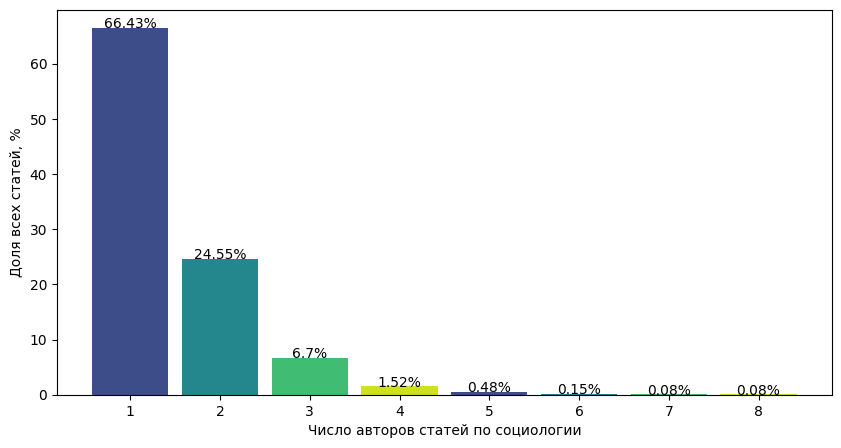

In [22]:
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i+1, y[i], f'{y[i]}%', ha = 'center')

fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette('viridis', 12)
plt.bar(x=p1['index'], height=p1['percent'].tolist(),
        width=0.85, color=colors[::-3]);

addlabels(p1['index'], p1['percent'].to_list()[::-1])
plt.xlabel("Число авторов статей по социологии")
plt.ylabel("Доля всех статей, %")
plt.savefig('numaut_rus.png')
plt.show()

In [ ]:
small_df['year_2'] = small_df['year']
p1 = pd.DataFrame(small_df.groupby('n_of_authors')[['year', 'year_2']].value_counts())
p1 = p1.reset_index().sort_values(by=['n_of_authors', 'year_2'])
p1 = p1.drop(['year_2'], axis = 1).rename(columns = {0:'count'})

# рассчитываем процент от всех статей по числу авторов по годам
p1_year = []
for i in range(2010, 2021+1):
    one_year = p1[p1['year'] == i]
    one_year['perc'] = round((one_year['count'] / one_year['count'].sum()) * 100, 2)
    p1_year.append(one_year)
p1 = pd.DataFrame()
for i in p1_year:
    p1 = pd.concat([p1, i])

authors_years = []
for i in range(1, 8+1):
    n_of_au = p1[p1['n_of_authors'] == i]
    authors_years.append(n_of_au)

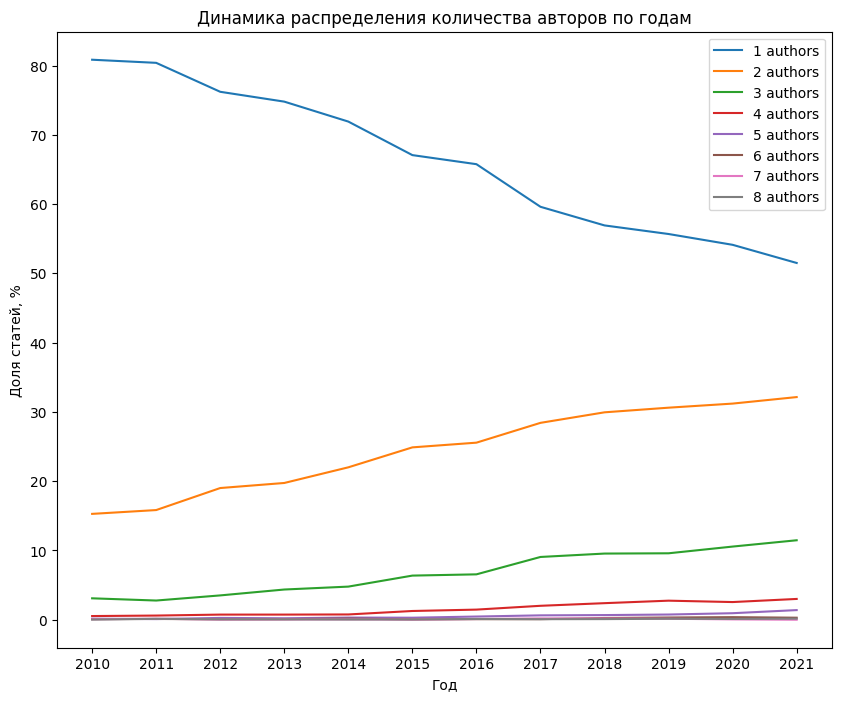

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('default')

x = [i for i in range(2010, 2021+1)]
ys = [authors_years[i]['perc'].values for i in range(0, 7+1)]
ys[-2] = np.append(ys[-2], 0)
for i in range(len(ys)):
    plt.plot(x, ys[i])

plt.xticks(ticks=[i for i in range(2010, 2021+1)])

plt.xlabel("Год");
plt.ylabel("Доля статей, %");
plt.legend(labels=[f'{i} authors' for i in range(1, 8+1)]);
plt.title('Динамика распределения количества авторов по годам')
plt.show()

## Пункт 2. Распределение цитирований

In [28]:
pd.DataFrame(df.describe()['cited']).reset_index()

,index,cited
0,count,75232.000000
1,mean,2.754812
2,std,7.394616
3,min,0.000000
4,25%,0.000000
5,50%,0.000000
6,75%,2.000000
7,max,384.000000


In [30]:
# самые популярные статьи, топ-10
p2 = df.sort_values('cited', ascending=False).head(10)[['ref', 'cited']]
p2

,ref,cited
36701,"ТОЩЕНКО, Ж.Т. Прекариат - новый социальный кла...",384
54904,"РАДАЕВ, В.В. МИЛЛЕНИАЛЫ НА ФОНЕ ПРЕДШЕСТВУЮЩИХ...",273
1927,"ЛАПИН, Н.И. ФУНКЦИОНАЛЬНО-ОРИЕНТИРУЮЩИЕ КЛАСТЕ...",237
6388,"Голенкова, З.Т. Новые социальные группы в совр...",202
38456,"Шалаев, В.П. ОСТОРОЖНО, МУТАЦИЯ: ЧЕЛОВЕК И ОБЩ...",195
9742,"Гудков, Л. Доверие в России: смысл, функции, с...",195
6904,"ДОКУКА, С.В. Клиповое мышление как феномен инф...",191
18888,"ЛАПИН, Н.И. Социокультурные факторы российской...",190
31806,"ШКАРАТАН, О.И. Прекариат: теория и эмпирически...",187
8685,"Мукомель, В.И. Интеграция мигрантов: вызовы, п...",170


In [32]:
need_columns = [f'new_id_{i}' for i in range(1, 8+1)]
need_columns.insert(0, 'id')
need_columns.insert(1, 'year')
need_columns.insert(2, 'cited')
small_df = df[need_columns]
small_df = small_df.replace('N/A', np.nan)
small_df['n_of_authors'] = 8 - small_df.isnull().sum(axis=1)
need_indexies = [i for i in range(small_df.shape[0]) if small_df.loc[i, 'n_of_authors'] == 0]
small_small_df = small_df.drop(labels=[i for i in range(small_df.shape[0]) if i not in need_indexies])
small_small_df['n_of_authors'] = need_n_of_authors
small_df = pd.concat([small_df, small_small_df])
small_df.drop_duplicates('id', inplace=True, keep='last')

p2 = pd.DataFrame(small_df.groupby('n_of_authors')['cited'].mean())
p2.reset_index(inplace=True)
p2['cited'] = round(p2['cited'], 2)
p2 # среднее число цитирований по числу авторов

,n_of_authors,cited
0,1,2.47
1,2,2.96
2,3,4.14
3,4,3.76
4,5,4.78
5,6,7.58
6,7,10.75
7,8,8.23


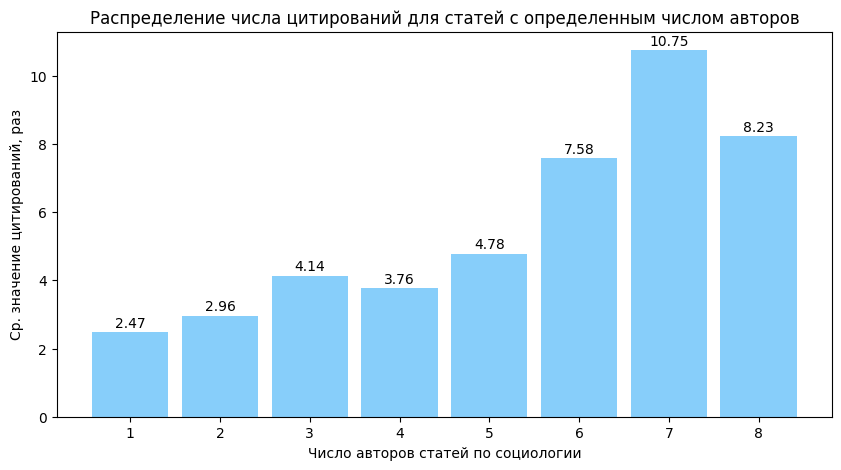

In [37]:
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i+1, y[i] + 0.15, f'{y[i]}', ha = 'center')

fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(p2['n_of_authors'], p2['cited'], width=0.85, color='lightskyblue');

addlabels(p2['n_of_authors'], p2['cited'])
plt.xlabel("Число авторов статей по социологии")
plt.ylabel("Ср. значение цитирований, раз")
plt.title("Распределение числа цитирований для статей с определенным числом авторов")
plt.show()

In [38]:
# описательные статистики по числу авторов
p2 = pd.DataFrame(small_df.groupby('n_of_authors')['cited'].agg(['mean', 'median', 'std', 'max']))
p2.reset_index(inplace=True)
p2['mean'] = round(p2['mean'], 2)
p2['std'] = round(p2['std'], 2)
p2

,n_of_authors,mean,median,std,max
0,1,2.47,0.0,7.02,384
1,2,2.96,0.0,7.53,202
2,3,4.14,1.0,9.12,187
3,4,3.76,1.0,7.62,72
4,5,4.78,1.0,10.97,82
5,6,7.58,1.0,13.67,75
6,7,10.75,3.0,16.84,63
7,8,8.23,2.0,13.62,59


In [40]:
from scipy.stats import pearsonr
p2_res = pearsonr(small_df['cited'],
                   small_df['n_of_authors'])
my_dict = {True: 'значимо', False: 'не значимо'}
print('Значение коэффициента корреляции между числом цитирований и числом авторов: ', p2_res[0])
print(f'Это значение статистически {my_dict[p2_res[1] < 0.01]}, так как значение коэффициента корреляции {p2_res[1]}')

Значение коэффициента корреляции между числом цитирований и числом авторов:  0.07366528684924253
Это значение статистически значимо, так как значение коэффициента корреляции 5.076638031419744e-91


In [135]:
p22 = pd.DataFrame(df.groupby('year').describe()['cited']['mean']).reset_index()
p22['mean'] = round(p22['mean'], 2)
p22.to_excel('mean_citations_of_publications_by_year.xlsx', index=None)
p22

,year,mean
0,2010,3.93
1,2011,3.40
2,2012,3.59
3,2013,3.45
4,2014,3.34
5,2015,3.29
6,2016,2.57
7,2017,2.59
8,2018,2.24
9,2019,1.80


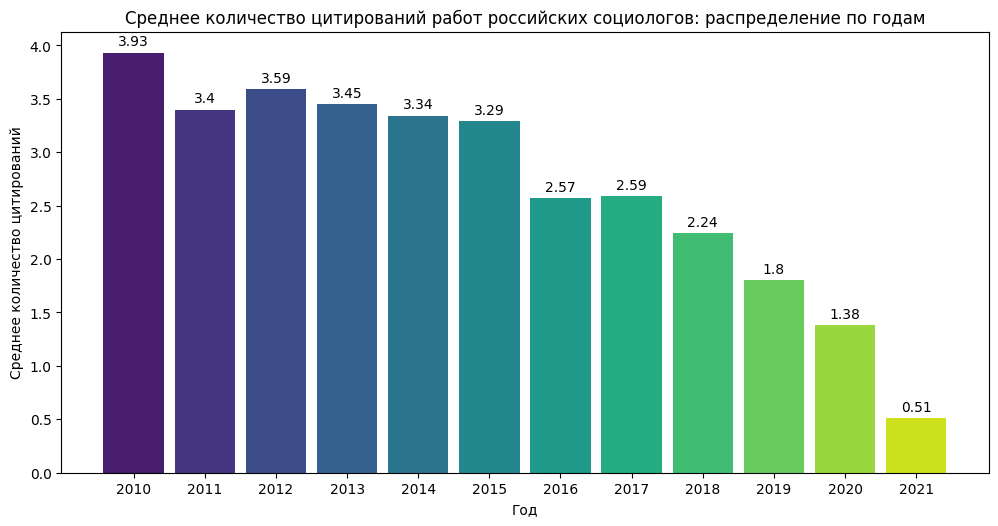

In [136]:
# фигуры
fig, ax = plt.subplots(figsize=(10, 5))
fig.tight_layout()
# цвета
colors = sns.color_palette('viridis', 12)

bars = plt.bar(p4['year'], p4['mean'], width=0.85, color=colors);
# подписываем число публикаций
# https://www.tutorialspoint.com/how-to-annotate-bars-in-bar-plot-with-matplotlib-in-python
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
    textcoords="offset points", ha='center', va='bottom')

plt.xticks(ticks=p4['year'], labels=[str(i) for i in range(2010, 2021+1)])

# надписи
plt.xlabel("Год")
plt.ylabel("Среднее количество цитирований")
plt.title("Среднее количество цитирований работ российских социологов: распределение по годам")
plt.show()

## Пункт 3. Абстракты и ключевые слова


In [44]:
p3 = pd.DataFrame(df['rubric'].value_counts()).reset_index()
p3['perc'] = round(p3['rubric'] / p3['rubric'].sum() * 100, 2)

p3.sort_values('rubric', ascending=False).head(10)['index'].values

array(['Социология',
       'Социология сфер социальной жизни, социальных явлений и институтов',
       'Общество как система. Социальные отношения и процессы',
       'Общие вопросы социологии', 'Социальные классы, общности и группы',
       'Методология социологии. Методика и техника социологических исследований',
       'Общие проблемы современной социологии',
       'Социология личности и поведения',
       'Историческая и региональная социология', 'Прикладная социология'],
      dtype=object)

In [51]:
print('% статей у которых есть абстракт на английском: ', end='')
print(round(len([i for i in df['abstract_eng'] if i != 'none']) / df.shape[0] * 100, 2), end='')
print('%')

print('% статей у которых есть абстракт на русском языке: ', end='')
print(round(len([i for i in df['abstract_ru'] if i != 'none']) / df.shape[0] * 100, 2), end='')
print('%')

% статей у которых есть абстракт на английском: 63.11%
% статей у которых есть абстракт на русском языке: 63.13%


In [54]:
# среднее число слов в абстракте
print('Среднее число слов в абстракте на русском (если абстракт не пуст): ', end='')
print(round(sum([len(i.split()) for i in df['abstract_ru'] if i != 'none'])/len([i for i in df['abstract_ru'] if i != 'none']), 2))

print('Среднее число символов в абстракте на русском (если абстракт не пуст) ', end='')
print(round(sum([len(i) for i in df['abstract_ru'] if i != 'none'])/len([i for i in df['abstract_ru'] if i != 'none']),2))

print('Среднее число слов в абстракте на английском (если абстракт не пуст): ', end='')
print(round(sum([len(i.split()) for i in df['abstract_eng'] if i != 'none'])/len([i for i in df['abstract_eng'] if i != 'none']), 2))

print('Среднее число символов в абстракте на английском (если абстракт не пуст) ', end='')
print(round(sum([len(i) for i in df['abstract_eng'] if i != 'none'])/len([i for i in df['abstract_eng'] if i != 'none']), 2))

Среднее число слов в абстракте на русском (если абстракт не пуст): 83.16
Среднее число символов в абстракте на русском (если абстракт не пуст) 726.68
Среднее число слов в абстракте на английском (если абстракт не пуст): 114.62
Среднее число символов в абстракте на английском (если абстракт не пуст) 761.22


### Топ слов в абстрактах

In [ ]:
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = pd.read_csv('https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt', header=None, names=['words'])
russian_stopwords = list(russian_stopwords['words'])
russian_stopwords.extend(['это', "наш", "мой", "мои", "ваши", "твои"])
russian_stopwords.extend(['the', 'of', 'and', 'in', 'to', 'a', 'is', 'as', 'on',
                          'are', 'for', 'that', 'with', 'this', 'by', 'it',
                         'at', 'from', 'be', 'what', 'was'])
russian_stopwords.extend(['which', 'an', 's', 'their'])
russian_stopwords.extend(['its', 'not'])

def get_clean_text(s: str):
    '''
    Функция get_clean_text(s) принимает на вход строку (string) и возвращает список из русских слов, которые есть в этой строке,
    из которых исключены стопслова и слова приведены к нормальной форме.

    Args:
        :string - строка, из которой необходимо получить список из "чистых" слов.
    Returns:
        :list - список с русскоязычными словами, приведенными к нормальной форме, из которых исключены стопслова
    Example:
        >>>> some_clean_text = get_clean_text('Каждый в цирке думает, что знает в цирке, но не каждый, что в цирке знает, что в цирке не каждый знает думает')
        >>>> some_clean_text
    '''
    s = s.lower() # приводим строку к нижнему регистру
    s = re.findall('[а-яёa-z]+', s) # берем только строки, состоящие из кириллических символов
    clean_words = []
    for i in tqdm(s):
        if i not in russian_stopwords:
            clean_words.append(i)
    final_words = []
    for i in tqdm(clean_words):
            final_words.append(morph.parse(i)[0].normal_form)

    clean_words = [i for i in s if i not in russian_stopwords] # берем только слова не-стопслова (частицы, местоимения)
    final_words = [morph.parse(i)[0].normal_form for i in clean_words] # нормализуем слова
    return final_words # возвращаем список

def get_most_frequent_words(s: str, top=100):
    '''
    Функция get_most_frequent_words(s) принимает на вход строку s и возвращает pandas.DataFrame с самыми частыми
    словами, использующимися в строке. В процессе слова предобрабатываются с помощью функции get_clean_text(s),
    приводятся к нормальной форме, исключаются стоп-слова. Функция позволяет получить самые частые слова на русском языке.

    Args:
        :s - string - строка, из которой необходимо получить самые часто используемые слова.
        :top=100 - int - число самых частых слов, которое нужно продемонстрировать в итоговой таблице
    Returns:
        :pandas.DataFrame с указанием слов и частотности их встречаемости в тексте. Таблица отсортирована от самых частых слов к самым редким.
        > word - string - слово;
        > count - int64 - число раз, которое слово встречается в поданной на вход строке.
    Example:
        >>>> small_df = get_most_frequent_words('Каждый в цирке думает, что знает в цирке, но не каждый, что в цирке знает, что в цирке не каждый знает думает')
        >>>> small_df

    '''
    # предобрабатываю изначальный текст
    clean_text = get_clean_text(s) # тут находится лист из слов

    # создаю словарь для подсчета частотности слов
    words_dict = {}
    for word in tqdm(clean_text):
        words_dict[word] = words_dict.get(word, 0) + 1

    # создаю pandas.DataFrame
    df = pd.DataFrame({'word': words_dict.keys(), 'count': words_dict.values()})
    df.sort_values('count', ascending=False, inplace=True)
    df = df.head(top)
    # возвращаю pandas.DataFrame
    return df

def get_word_cloud_from_one_big_string(s: str,
                                       max_words=100,
                                       colormap='Pastel1',
                                       background_color="black",
                                       collocations=False):
    '''
    Функция get_word_cloud_from_one_big_string(s) принимает на вход большую строку s и
    рисует большое облако слов.

    Args:
        :s - string - строка, из которой необходимо получить облако слов;
        :max_words=100 - int - максимаальное число слов, отражаемое на картинке.
        :colormap = "Pastel1" - палитра для отрисовки облака слов;
        :background_color = "black" - цвет для фона
        :collocations = False - изображаем пары слов или только отдельные слова;

    Returns:
        :None
    Example:
        >>>> get_word_cloud_from_one_big_string("Проповедь Иисуса Христа по внешним чертам своего оформления примыкает к весьма древней библейской традиции пророческой речи. Речь эта была ритмической и пользовалась множеством созвучий; и ритмы, и созвучия (особенно заметные при попытках обратного перевода речений Христа на арамейский язык) имели, между прочими, утилитарную мнемотехническую функцию, помогая ритмико-синтаксическому отрезку задержаться в памяти слушателя. У древней проповеди — особая интонация, решительно непохожая, например, на ту интонацию чуть ли не митингового ораторствования, которая так характерна для известного фильма Пазолини «Евангелие от Матфея». Hашему воображению лучше ориентироваться на чуть-чуть речитативное произнесение, столь неизбежное для сферы учительства в восточном роде; этот легкий распев нисколько не мешает ни взрывам экспрессии (как учат нас мелодии фольклорных причитаний), ни предельной простоте, однако задает тому и другому особый контекст.")
    '''

    list_with_clean_words = get_clean_text(s) # получаем чистые слова - у нас получается список

    # создаем wordcloud
    wordcloud = WordCloud(width=2000, height=1500, margin=20, random_state=1,
                          max_words=max_words,
                          colormap=colormap,
                          background_color = background_color,
                          collocations=collocations)\
                .generate(' '.join(list_with_clean_words))

    # рисуем wordcloud
    plt.figure(figsize=[40, 30])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [56]:
non_empty_ru_abstracts = df[df['abstract_ru'] != 'none']['abstract_ru'].tolist()
non_empty_ru_abstracts_string = ' '.join(non_empty_ru_abstracts)

non_empty_eng_abstracts = df[df['abstract_eng'] != 'none']['abstract_eng'].tolist()
non_empty_eng_abstracts_string = ' '.join(non_empty_eng_abstracts)

In [ ]:
most_popular_words_in_ru_abstracts = get_most_frequent_words(non_empty_ru_abstracts_string, top=300)
most_popular_words_in_ru_abstracts

In [ ]:
get_word_cloud_from_one_big_string(s=non_empty_ru_abstracts_string,
                                       max_words=100,
                                       colormap='turbo',
                                       background_color="black",
                                       collocations=False)

In [ ]:
most_popular_words_in_eng_abstracts = get_most_frequent_words(non_empty_eng_abstracts_string, top=300)
most_popular_words_in_eng_abstracts

In [ ]:
get_word_cloud_from_one_big_string(s=non_empty_eng_abstracts_string,
                                       max_words=100,
                                       colormap='gnuplot',
                                       background_color="black",
                                       collocations=False)

### Топ ключевых слов

In [106]:
keywords_ru = df[df.keywords_ru != 'none']['keywords_ru'].to_list()

keywords_ru = [i.lstrip("'[").rstrip("]'").split(", '") for i in keywords_ru]
keywords_ru = [i.rstrip("'") for m in keywords_ru for i in m]

In [ ]:
for i in keywords_ru:
  keywords_ru.remove('')

In [122]:
cnt_ru = Counter(keywords_ru)
cnt_ru.most_common()[:50]

[('молодежь', 3730),
 ('семья', 1751),
 ('общество', 1600),
 ('ценности', 1534),
 ('культура', 1329),
 ('образование', 1127),
 ('глобализация', 1123),
 ('социализация', 1121),
 ('миграция', 994),
 ('гражданское общество', 931),
 ('идентичность', 931),
 ('модернизация', 917),
 ('государство', 880),
 ('управление', 771),
 ('социология', 745),
 ('социальные сети', 735),
 ('интернет', 730),
 ('россия', 701),
 ('коммуникация', 697),
 ('рынок труда', 690),
 ('личность', 684),
 ('регион', 682),
 ('ценностные ориентации', 671),
 ('социальная политика', 670),
 ('студенты', 626),
 ('адаптация', 604),
 ('социальное самочувствие', 594),
 ('конфликт', 591),
 ('власть', 583),
 ('интеграция', 567),
 ('общественное мнение', 562),
 ('патриотизм', 561),
 ('социальная работа', 549),
 ('социологическое исследование', 549),
 ('доверие', 542),
 ('религия', 536),
 ('качество жизни', 532),
 ('толерантность', 525),
 ('гендер', 524),
 ('социальный институт', 522),
 ('социальный капитал', 522),
 ('социальная стр

In [ ]:
keywords_eng = df[df.keywords_eng != 'none']['keywords_eng'].to_list()

keywords_eng = [i.lstrip("'[").rstrip("]'").split(", '") for i in keywords_eng]
keywords_eng = [i.rstrip("'") for m in keywords_eng for i in m]

for i in keywords_eng:
  keywords_eng.remove('')

In [127]:
cnt_eng = Counter(keywords_eng)
cnt_eng.most_common()[:50]

[('youth', 2842),
 ('society', 1337),
 ('family', 1263),
 ('values', 1218),
 ('culture', 1029),
 ('education', 986),
 ('globalization', 871),
 ('migration', 836),
 ('students', 835),
 ('socialization', 813),
 ('identity', 788),
 ('civil society', 715),
 ('modernization', 693),
 ('communication', 629),
 ('state', 609),
 ('management', 599),
 ('region', 578),
 ('russia', 577),
 ('internet', 571),
 ('sociology', 533),
 ('social networks', 478),
 ('adaptation', 467),
 ('social policy', 463),
 ('employment', 453),
 ('public opinion', 444),
 ('religion', 433),
 ('patriotism', 429),
 ('social work', 428),
 ('gender', 428),
 ('mass media', 427),
 ('social capital', 424),
 ('trust', 424),
 ('social structure', 423),
 ('integration', 422),
 ('social well-being', 421),
 ('social adaptation', 417),
 ('personality', 413),
 ('sociological research', 409),
 ('health', 408),
 ('tolerance', 406),
 ('conflict', 405),
 ('information society', 390),
 ('information', 381),
 ('labor market', 374),
 ('higher

## Пункт 4. Статистики по авторам

In [140]:
need_columns = [f'new_id_{i}' for i in range(1, 8+1)]
need_columns.insert(0, 'id')
need_columns.insert(1, 'year')
small_df = df[need_columns]
small_df = small_df.replace('N/A', np.nan)
small_df['n_of_authors'] = 8 - small_df.isnull().sum(axis=1)

strange_ids = small_df[small_df['n_of_authors'] == 0]['id'].tolist()
df[df['id'].isin(strange_ids)]

,id,genreId,author_1_id,author_1_affiliation_id,author_1_ru last name,author_1_ru initials,author_1_ru affiliation,author_1_eng last name,author_1_eng initials,author_1_eng affiliation,...,url,ref,new_id_1,new_id_2,new_id_3,new_id_4,new_id_5,new_id_6,new_id_7,new_id_8
75083,32383601,4,0,[none],none,none,[none],none,none,['none'],...,none,"Профессия""тьютор""всовременном российском социа...",N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
75084,37288426,4,0,[none],none,none,[none],none,none,['none'],...,none,MANAGEMENT OF NATIONAL RELATIONS AS THE IMPLEM...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
75085,39822976,4,0,[none],none,none,[none],none,none,['none'],...,None,Образ жизни и отношение к здоровью российских ...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
75092,42441176,4,0,[none],none,none,[none],none,none,['none'],...,None,Проекты местного развития в Приладожье: причин...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


In [141]:
small_df = small_df[small_df['n_of_authors'] != 0]

In [153]:
all_authors = []
for i in range(1, 9):
    one_column = small_df[f'new_id_{i}']
    unique_authors = [str(i).strip() for i in set(small_df[f'new_id_{i}'].tolist())]
    all_authors.extend(unique_authors)

In [155]:
all_authors = list(set(all_authors))
all_authors = sorted(all_authors)

In [ ]:
p5 = pd.DataFrame(all_authors)
p5.columns = ['author']
for i in range(2010, 2021+1):
    p5[f'{i}'] = 0

p5.index = p5['author']

problem_authors = []
all_authors_works_by_year = []
# идем по авторам
for author in tqdm(all_authors):
    try:
        n_of_works_by_years = []
        # идем по годам
        for i in range(2010, 2021+1):
            one_year = small_df[small_df['year'] == i]
            articles_in_this_year = 0
            # идем по авторам (new_id_1, new_id_2 и др.)
            for j in range(1, 8+1):
                need_column = one_year[f'new_id_{j}']
                articles_in_this_year += need_column.str.contains(f'{author}').sum()
            n_of_works_by_years.append(articles_in_this_year)
        n_of_works_by_years.insert(0, author)
    except:
        n_of_works_by_years = [0 for i in range(12)]
        n_of_works_by_years.insert(0, author)
        problem_authors.append(author)
    all_authors_works_by_year.append(n_of_works_by_years)

authors = pd.DataFrame(all_authors_works_by_year)
name_of_columns = [f'{i}' for i in range(2010, 2021+1)]
name_of_columns.insert(0, 'author')
authors.columns = name_of_columns

In [ ]:
problem_authors = ['0_(E_Harlashi_7533',
 '0_A(_Epshtejn_none',
 '0_JUJU_Genkin (_980',
 '0_N(_Fligstin_192',
 '0_RS_Apenok (_5246',
 '0_V_Hanin (z_none',
 '593924_AH_Tezjel (_2541']

problem_authors_df = pd.DataFrame()
for i in range(0, 6+1):
    author = problem_authors[i]
    for j in range(1, 8+1):
        author_one_id = small_df[small_df[f'new_id_{j}'] == author]
        problem_authors_df = pd.concat([problem_authors_df, author_one_id])
# problem_authors_df


authors_dict = {'0_(E_Harlashi_7533': [2018, 2018],
 '0_A(_Epshtejn_none': [2015],
 '0_JUJU_Genkin (_980': [2019],
 '0_N(_Fligstin_192': [2010],
 '0_RS_Apenok (_5246': [2014],
 '0_V_Hanin (z_none': [2010, 2010, 2013],
 '593924_AH_Tezjel (_2541':[2015]}

solved_problem_authors_df = pd.DataFrame(index=problem_authors,
                                            columns=[str(i) for i in range(2010, 2021+1)])
solved_problem_authors_df = solved_problem_authors_df.replace(np.nan, 0)
solved_problem_authors_df
# проходимся по словарю выше
# что-то не сработало, ну ладно...
# for k,v in authors_dict.items():
#     for i in v:
#         print(k, i)
#         solved_problem_authors_df.loc[k, str(v)] += 1


# не делайте так, это плохо и запрещенный прием

# solved_problem_authors_df.loc['0_(E_Harlashi_7533', '2018'] += 1
# solved_problem_authors_df.loc['0_(E_Harlashi_7533', '2018'] += 1
# solved_problem_authors_df.loc['0_A(_Epshtejn_none', '2015'] += 1
# solved_problem_authors_df.loc['0_JUJU_Genkin (_980', '2019'] += 1
# solved_problem_authors_df.loc['0_N(_Fligstin_192', '2010'] += 1
# solved_problem_authors_df.loc['0_RS_Apenok (_5246', '2014'] += 1
# solved_problem_authors_df.loc['0_V_Hanin (z_none', '2010'] += 1
# solved_problem_authors_df.loc['0_V_Hanin (z_none', '2010'] += 1
# solved_problem_authors_df.loc['0_V_Hanin (z_none', '2013'] += 1
# solved_problem_authors_df.loc['593924_AH_Tezjel (_2541', '2015'] += 1

authors.loc[problem_authors] = solved_problem_authors_df

In [ ]:
authors_by_year = pd.DataFrame(index=[i for i in range(2010, 2021+1)],
                              columns=['number'],
                              data=[[0]])
for i in range(2010, 2021+1):
    column = authors[f'{i}']
    value = column.apply(lambda x: x > 0).sum()
    authors_by_year.loc[i, 'number'] = value

authors_by_year.reset_index(inplace=True)
authors_by_year.columns = ['year', 'number']

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.tight_layout()
# цвета
colors = sns.color_palette('viridis', 12)

bars = plt.bar(authors_by_year['year'], authors_by_year['number'], width=0.85, color=colors);
# подписываем число публикаций
# https://www.tutorialspoint.com/how-to-annotate-bars-in-bar-plot-with-matplotlib-in-python
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
    textcoords="offset points", ha='center', va='bottom')

plt.xticks(ticks=authors_by_year['year'], labels=[str(i) for i in range(2010, 2021+1)])

# надписи
plt.xlabel("Год")
plt.ylabel("Число уникальных авторов")
plt.title("Распределение числа уникальных авторов, участвовавших в написании статей по социологии в этом году")
plt.show()

In [ ]:
authors_by_year['perc'] = round(authors_by_year['number'] / authors.shape[0]*100, 2)
# фигуры
fig, ax = plt.subplots(figsize=(10, 5))
fig.tight_layout()
# цвета
colors = sns.color_palette('viridis', 12)

bars = plt.bar(authors_by_year['year'], authors_by_year['perc'], width=0.85, color=colors);
# подписываем число публикаций
# https://www.tutorialspoint.com/how-to-annotate-bars-in-bar-plot-with-matplotlib-in-python
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
    textcoords="offset points", ha='center', va='bottom')

plt.xticks(ticks=authors_by_year['year'], labels=[str(i) for i in range(2010, 2021+1)])

# надписи
plt.xlabel("Год")
plt.ylabel("Доля уникальных авторов от уникальных авторов вообще, %")
plt.title("Процент уникальных авторов, участвовавших в написании статей по социологии в этом году")
plt.show()

In [ ]:
years = [f'{i}' for i in range(2010, 2021+1)]
authors_mean_by_year = pd.DataFrame(authors.loc[:, years].mean())
authors_mean_by_year.reset_index(inplace=True)
authors_mean_by_year.columns = ['year', 'mean_articles']

authors_in_how_many_years = pd.DataFrame(authors.loc[:, years].apply(lambda x: x > 0).sum(axis=1))
authors_in_how_many_years = pd.DataFrame(authors_in_how_many_years[0].value_counts()).reset_index()
authors_in_how_many_years.columns = ['year', 'n_of_authors']

In [ ]:
authors_in_how_many_years = authors_in_how_many_years[authors_in_how_many_years['year'] != 0]
# фигуры
fig, ax = plt.subplots(figsize=(10, 5))
fig.tight_layout()
# цвета
colors = sns.color_palette('viridis', 12)

bars = plt.bar(authors_in_how_many_years['year'], authors_in_how_many_years['n_of_authors'], width=0.85, color=colors);
# подписываем число публикаций
# https://www.tutorialspoint.com/how-to-annotate-bars-in-bar-plot-with-matplotlib-in-python
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
    textcoords="offset points", ha='center', va='bottom')

plt.xticks(ticks=[i for i in range(1, 12+1)], labels=[str(i) for i in range(1, 12+1)])

# надписи
plt.ylabel("Число уникальных авторов")
plt.xlabel("Число лет, когда автор писал статьи по социологии за 2010-2021 (вкл.)")
plt.title("Публикационная активность российских социологов")
plt.show()

In [ ]:
authors_in_how_many_years['perc'] = round(authors_in_how_many_years['n_of_authors'] / authors.shape[0] * 100, 2)
fig, ax = plt.subplots(figsize=(10, 5))
fig.tight_layout()
# цвета
colors = sns.color_palette('viridis', 12)

bars = plt.bar(authors_in_how_many_years['year'], authors_in_how_many_years['perc'], width=0.85, color=colors);
# подписываем число публикаций
# https://www.tutorialspoint.com/how-to-annotate-bars-in-bar-plot-with-matplotlib-in-python
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
    textcoords="offset points", ha='center', va='bottom')

plt.xticks(ticks=[i for i in range(1, 12+1)], labels=[str(i) for i in range(1, 12+1)])

# надписи
plt.xlabel("Число лет, когда автор писал статьи по социологии за 2010-2021 (вкл.)")
plt.ylabel("Доля уникальных авторов, %")
plt.title("Публикационная активность российских социологов")
plt.show()

In [ ]:
# author - автор
# n_of_years - число лет с 2010 по 2021 когда автор участвовал в написании хотя бы одной статьи
top_active_authors = pd.DataFrame(authors.loc[:, years].apply(lambda x: x > 0).sum(axis=1))
top_active_authors.columns = ['n_of_years']
top_active_authors.sort_values('n_of_years', ascending=False, inplace=True)

In [ ]:
publication_activity_descriptive = pd.DataFrame(pd.DataFrame(authors.loc[:, years].apply(lambda x: x > 0).sum(axis=1))[0].describe())
publication_activity_descriptive[0] = round(publication_activity_descriptive[0], 2)

In [ ]:
top_active_authors = pd.DataFrame(authors.loc[:, years].apply(lambda x: x > 0).sum(axis=1))
top_active_authors = top_active_authors[top_active_authors[0] == 12]
authors['n_of_articles'] = authors.sum(axis=1)

In [ ]:
p6 = authors.sort_values('n_of_articles', ascending=False)

In [ ]:
p6_copy = p6
p6_copy['n_of_articles'] = p6_copy['n_of_articles'].apply(lambda x: x if x < 10 else 10)

p6_copy = pd.DataFrame(p6_copy['n_of_articles'].value_counts())
p6_copy.reset_index(inplace=True)
p6_copy.columns = ['number', 'authors']
p6_copy.sort_values('number', inplace=True)
p6_copy['authors_perc'] = round(p6_copy['authors'] / authors.shape[0] * 100, 2)
p6_copy = p6_copy[p6_copy['number'] != 0]

# фигуры
fig, ax = plt.subplots(figsize=(10, 5))
fig.tight_layout()
# цвета
colors = sns.color_palette('viridis', 10)

bars = plt.bar(p6_copy['number'], p6_copy['authors'], width=0.85, color=colors);
# подписываем число публикаций
# https://www.tutorialspoint.com/how-to-annotate-bars-in-bar-plot-with-matplotlib-in-python
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
    textcoords="offset points", ha='center', va='bottom')

labels = [i for i in range(1, 9+1)]
labels.append('10 и более')
plt.xticks(ticks=[i for i in range(1, 11)], labels=labels)

# надписи
plt.xlabel("Число статей")
plt.ylabel("Число авторов, написавших такое количество статей")
plt.title("Публикационная активность российских социологов за 2010-2021 г.")
plt.show()

In [ ]:
# фигуры
fig, ax = plt.subplots(figsize=(10, 5))
fig.tight_layout()
# цвета
colors = sns.color_palette('viridis', 10)

bars = plt.bar(p6_copy['number'], p6_copy['authors_perc'], width=0.85, color=colors);
# подписываем число публикаций
# https://www.tutorialspoint.com/how-to-annotate-bars-in-bar-plot-with-matplotlib-in-python
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
    textcoords="offset points", ha='center', va='bottom')

labels = [i for i in range(1, 9+1)]
labels.append('10 и более')
plt.xticks(ticks=[i for i in range(1, 11)], labels=labels)

# надписи
plt.xlabel("Число статей")
plt.ylabel("Доля авторов, написавших такое количество статей, %")
plt.title("Публикационная активность российских социологов за 2010-2021 г.")
plt.show()

In [ ]:
p6_descriptive = pd.DataFrame(authors['n_of_articles'].describe())
p6_descriptive['n_of_articles'] = round(p6_descriptive['n_of_articles'], 2)
p6_descriptive

### Пункт 4.1. Публикационная активность

In [138]:
p5 = pd.DataFrame(df['year'].value_counts()).reset_index()
p5.sort_values('index', inplace=True)
p5.to_excel('number_of_publications_by_year.xlsx', index=None)
p5

,index,year
10,2010,4561
8,2011,5478
6,2012,6218
5,2013,6328
3,2014,7135
1,2015,8260
0,2016,8536
2,2017,7314
4,2018,6818
7,2019,5884


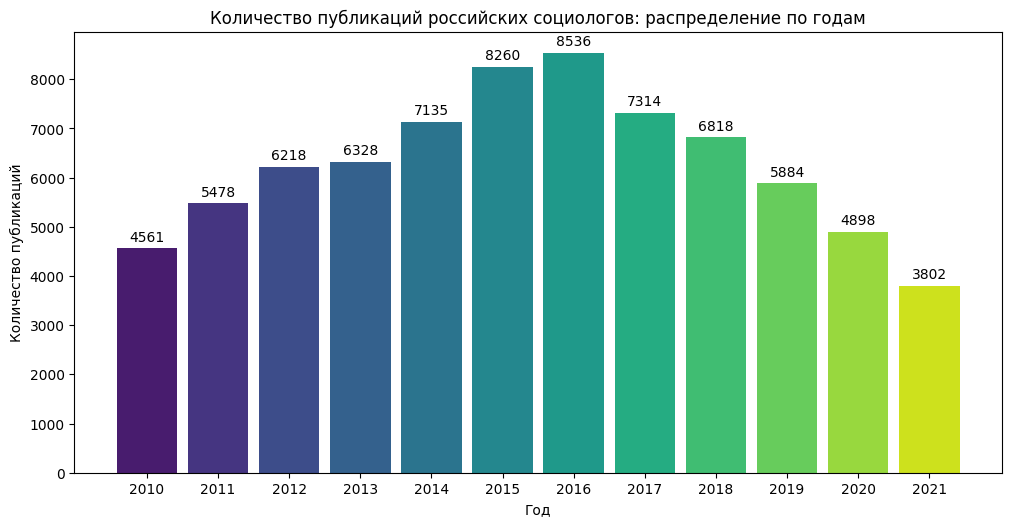

In [139]:
# фигуры
fig, ax = plt.subplots(figsize=(10, 5))
fig.tight_layout()
# цвета
colors = sns.color_palette('viridis', 12)

bars = plt.bar(p5['index'], p5['year'], width=0.85, color=colors);
# подписываем число публикаций
# https://www.tutorialspoint.com/how-to-annotate-bars-in-bar-plot-with-matplotlib-in-python
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
    textcoords="offset points", ha='center', va='bottom')

plt.xticks(ticks=p5['index'], labels=[str(i) for i in range(2010, 2021+1)])

# надписи
plt.xlabel("Год")
plt.ylabel("Количество публикаций")
plt.title("Количество публикаций российских социологов: распределение по годам")
plt.show()